# Project I: Parameter estimation for a toy model of an effective field theory
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 12-Sep-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional and only gives extra points. See examination rules on the course web page.
- Hand-in your written report via Canvas.

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

## Main task
The overall project goal is to reproduce various results in a paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618).  It's a long paper, so don't try to read all of it!  We'll guide you to the relevant parts. Sec. II of the paper is the most relevant, but you don't need to understand all of it. 

The paper uses toy models for effective field theories (EFTs), namely Taylor series of some specified functions, to present guidelines for parameter estimation. We will not discuss the EFT concept in any detail, but will just mention that it is a type of approximation, or effective theory, for an underlying physical theory, such as a quantum field theory. An EFT includes the appropriate degrees of freedom to describe physical phenomena occurring at a chosen length scale or energy scale, while not resolving substructure and degrees of freedom at shorter distances (or, equivalently, at higher energies). 

In our case, the function
$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$
represents the true, underlying theory.  It has a Taylor expansion
$$
g(x) = 0.25 + 1.57 x + 2.47 x^2 + 1.29 x^3 + \cdots
$$
that is known for this toy example (but would not be in a real situation).

Our model for an EFT for this "theory" is then
$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i,
$$
where $a_i$ are the parameters of the EFT, sometimes known as low-energy constants (LECs).

Your general task is to fit a few of the parameters $a_i$ using a Bayesian approach, and analyze the results. 

* **Your specific goal is to reproduce and interpret Figure 1 on page 6 of the arXiv preprint. This figure shows joint pdfs for the EFT parameters using two different priors. One of these priors encapsulates the physics expectation that the parameters should be of "natural" size (order one).**
* **A secondary goal is to reproduce Figs. 3 and 4 that show predictions of the inferred EFT with error bands (you can use $k=k_\mathrm{max}=3$ as in the first task).**. 

You should use emcee to sample the joint pdfs and you should use corner to make plots.

### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* This a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the exercise notebooks.
* Load the data set that was used in the paper: [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat). The three columns correspond respectively to $x_j$, the measured data $d(x_j) \equiv d_j$ and the error in terms of a standard deviation $\sigma_j$.
* Define functions for the two choices of prior: a uniform prior, $|a_i|<100$, and a Gaussian naturalness prior given by Eq. (24) with $\bar{a}=5$. Use the log prior.
* Define a function for the likelihood (Eq. 9). It will require the chi-squared measure. Use the log likelihood.
* Call emcee to sample the posteriors. 
* Use corner to create plots.  You can read the answers for the tables from the corner plots.
* Don't try to do too much in your code at first (start with a low order). 
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.


### Comments and suggestions
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(samples, [16, 50, 84],axis=0)` might be useful to extract numerical values for the credibility region and the mean from a python array `samples`of shape (nsamples,ndimensions).
* When reproducing Figures 3 and 4 you can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)

## Optional: Part 2 (extra points)
* Reproduce and interpret Table III on page 12 of the arXiv preprint. 
* Repeat analysis with same function but different data precision and/or quantity (number of data points). You will then have to generate the data yourself using Eq. (2) and the true function Eq. (23). It is probably wise to stay in the $0 < x \le 1/\pi$ range.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
x,d,sigma = np.loadtxt('data.dat',unpack=True)

Model:
$$
g_{th}(x) = \sum_{i=0} a_i x^{i}
$$



Likelihood:

$$
p(D|a) = \prod_{j=1}^{N_d}\frac{1}{\sqrt{2\pi}\sigma_{j,exp}}e^{\frac{-\chi^{2}}{2}} \Rightarrow \\
ln(p(D|a) = \sum_{j=1}^{N_d}-ln\left(\sqrt{2\pi}\sigma_{j,exp}\right) + \frac{-\chi^{2}}{2}
$$
with $\chi$
$$
\chi^{2}=\sum_{i=1}^{N_d}\left(\frac{d_i - g_{th}(x_i)}{\sigma_{i,exp}}\right)^2
$$

using a uniform likelihood makes the postrior equal to the likelihood by some normalization constant


In [3]:
def model(x,a):
    X = np.array([x**i for i in range(4)])
    return np.sum(X.T*a,axis=1)
    
def chi_square(x,d,sigma,a):
    return np.sum(((d-model(x,a))/sigma)**2)
    
def log_likelihood(x,d,sigma,a):
    c = -np.sqrt(2*np.pi)*sigma
    e = -chi_square(x,d,sigma,a)/2
    return np.sum(c+e)

def log_prior(a):
    if np.linalg.norm(a)>1000:
        return -np.inf
    else:
        return 0

def log_posterior(a):
    return log_likelihood(x,d,sigma,a) + log_prior(a)

Code for mcmc-sampler:

In [43]:
import emcee

Nwalker = 10
Ndim = 4
Nburn = 500
Nstep = 500

p0 = [10*np.random.randn(Ndim) for i in range(Nwalker)]
sampler = emcee.EnsembleSampler(Nwalker,Ndim,log_posterior)

pos, prob, state = sampler.run_mcmc(p0, Nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(p0, Nstep)




samples = sampler.chain.reshape((-1, Ndim))

print('done')



done


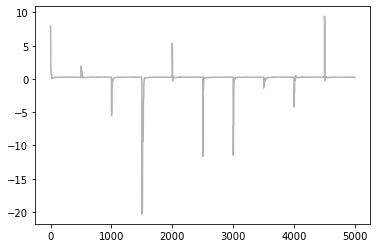

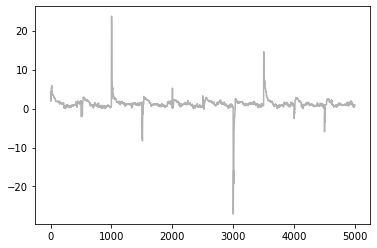

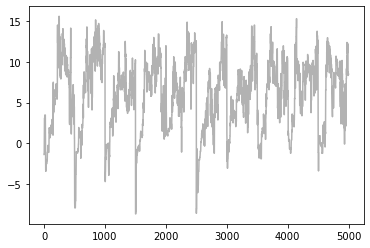

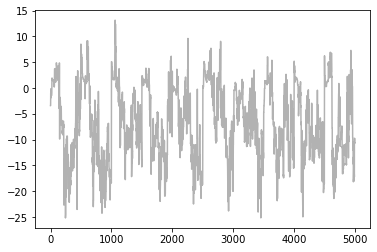

In [44]:
for i in range(4):
    plt.figure()
    plt.plot(samples[:,i].T, '-', color='k', alpha=0.3)

'\n# With some manual efforts, we can add the maximum-likelihood estimate from the frequentist analysis \nmaxlike_results = (mu_est,sigma_est)\n\n# First, extract the axes\naxes = np.array(fig.axes).reshape((ndim, ndim))\n\n# Then, loop over the diagonal\nfor i in range(ndim):\n    ax = axes[i, i]\n    ax.axvline(maxlike_results[i], color="r")\n\n# And finally, loop over the histograms\nfor yi in range(ndim):\n    for xi in range(yi):\n        ax = axes[yi, xi]\n        ax.axvline(maxlike_results[xi], color="r")\n        ax.axhline(maxlike_results[yi], color="r")\n        ax.plot(maxlike_results[xi], maxlike_results[yi], "sr")\n'

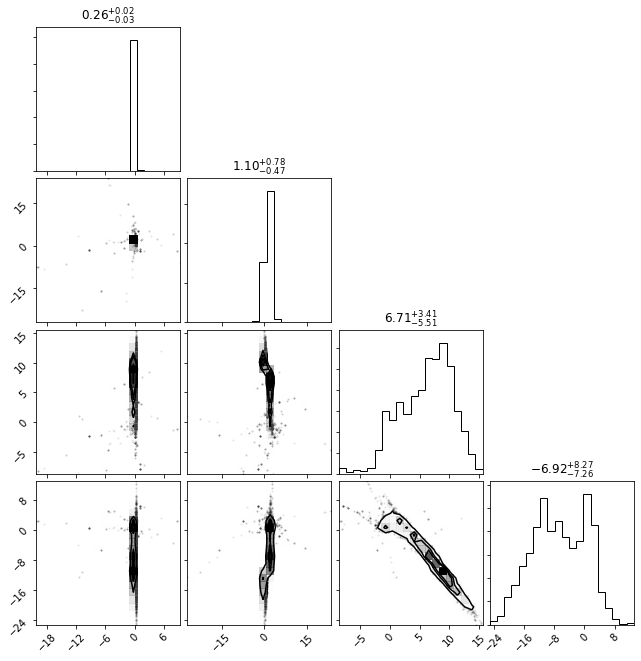

In [46]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples, #labels=["$\mu$", "$\sigma$"],
                      #truths=[mu_true, sigma_true],quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

'''
# With some manual efforts, we can add the maximum-likelihood estimate from the frequentist analysis 
maxlike_results = (mu_est,sigma_est)

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Then, loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(maxlike_results[i], color="r")

# And finally, loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(maxlike_results[xi], color="r")
        ax.axhline(maxlike_results[yi], color="r")
        ax.plot(maxlike_results[xi], maxlike_results[yi], "sr")
'''

In [ ]:
from scipy.stats import norm
from scipy.stats import uniform
 
def sampler(posterior_func, no_of_samples=4, start_position=[1,1,1,1], 
            proposal_width=1., plot=False):

    # starting parameter position
    current_position = start_position
    
    samples = [current_position]
    
    # creating randomized steps
    proposed_step = np.reshape(norm.rvs(size=no_of_samples*4, scale=proposal_width, loc=0), (no_of_samples, 4))
    
    # creating acceptance variables
    accept_variable = uniform.rvs(size=no_of_samples)
    for i in range(no_of_samples):
        # suggest new position

        proposed_position= current_position + proposed_step[i]
    
        # Compute posteriors of current and proposed position       
        p_current = posterior_func(current_position)
        p_proposal = posterior_func(proposed_position)
        
        # Acceptance probability
        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        
        if p_current == 0:
            p_accept = 2 # prevents dividing by zero
        else:
            p_accept = p_proposal / p_current
        
        # Accept proposal?
        accept = p_accept>accept_variable[i]
        
        # Visualization
        if plot:
            assert no_of_samples < 11, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accept, samples, i)
            
        # possibly change current position
        if accept:
            current_position = proposed_position
        samples.append(current_position)
        
    return np.array(samples)


l = sampler(log_posterior,no_of_samples=1000, proposal_width=0.01)


plt.figure()
plt.plot(l[:,0])
plt.plot(l[:,1])
plt.plot(l[:,2])
plt.plot(l[:,3])

